# Basic Hands-On 1: Neural networks for regression - simple energy reconstruction with TA

In this example, we want to do a reconstruction for a detector such as TA surface array.  As we just saw in the previous examples, we want to estimate a quantity in reality from many different features. Here, the two features are total signal and arrival times, which are located in two different files. The TA reconstruction framework exploits the spatial information of each event by defining a 7x7 tile out of the surface array. We will learn how to visualize the input data and how to move from a fully connected simple network to a convolutional network.


### 1. Load data from ascii file and visualize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


Read data from files. Note that first 5 columns are identical. These are the columns: 
* 0: id  
* 1: energy  
* 2,3,4: shower axis (nx, ny, nz)  
* 5-54: total signal and arrival times. For each event (row), 7x7=49 values. The shape is restored using the `reshape` method.


In [2]:
data_total_signal = np.loadtxt("total_signal_prot.txt", comments="#", dtype=np.float32)
data_arrival_times = np.loadtxt("arrival_times_prot.txt", comments="#", dtype=np.float32)

data = dict()
data["energy"] = data_total_signal[:, 1]
data["shower_axis"] = data_total_signal[:, 2:5]
data["total_signal"] = data_total_signal[:, 5:].reshape(-1, 7, 7)
data["arrival_times"] = data_arrival_times[:, 5:].reshape(-1, 7, 7)

### 2. Investigate numerical data of event with `evt_id`

_Note_: Change evt_id to visualize another event

Each event has a dimension of 7x7-tile within the TA SD array.


In [3]:
evt_id = 59
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nArrival times")
print(data["arrival_times"][evt_id])
print("\nTotal signal")
print(data["total_signal"][evt_id])

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Arrival times
[[    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.  29439.6 31178.4     0.      0. ]
 [    0.      0.      0.  29119.8 31008.5     0.      0. ]
 [    0.      0.      0.  30448.9     0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]]

Total signal
[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     59.4497 64.2563  0.      0.    ]
 [ 0.      0.      0.     76.1689 37.1075  0.      0.    ]
 [ 0.      0.      0.     20.2708  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]]


Numbers show which detectors saw a signal. The remaining detectors in the array show values of 0. Visualizing the data before feeding it into a network is crucial. In case of missing entries in the files, we need to assign a 0 or nan/infinity value (depending on your problem). DNNs cannot deal with missing data.

Before we will train a network, let's take a closer look at the data:

### 3. Visualize event: heatmaps of arrival times and total signal

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Arrival times
[[    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.  29439.6 31178.4     0.      0. ]
 [    0.      0.      0.  29119.8 31008.5     0.      0. ]
 [    0.      0.      0.  30448.9     0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]]

Total signal
[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     59.4497 64.2563  0.      0.    ]
 [ 0.      0.      0.     76.1689 37.1075  0.      0.    ]
 [ 0.      0.      0.     20.2708  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]]


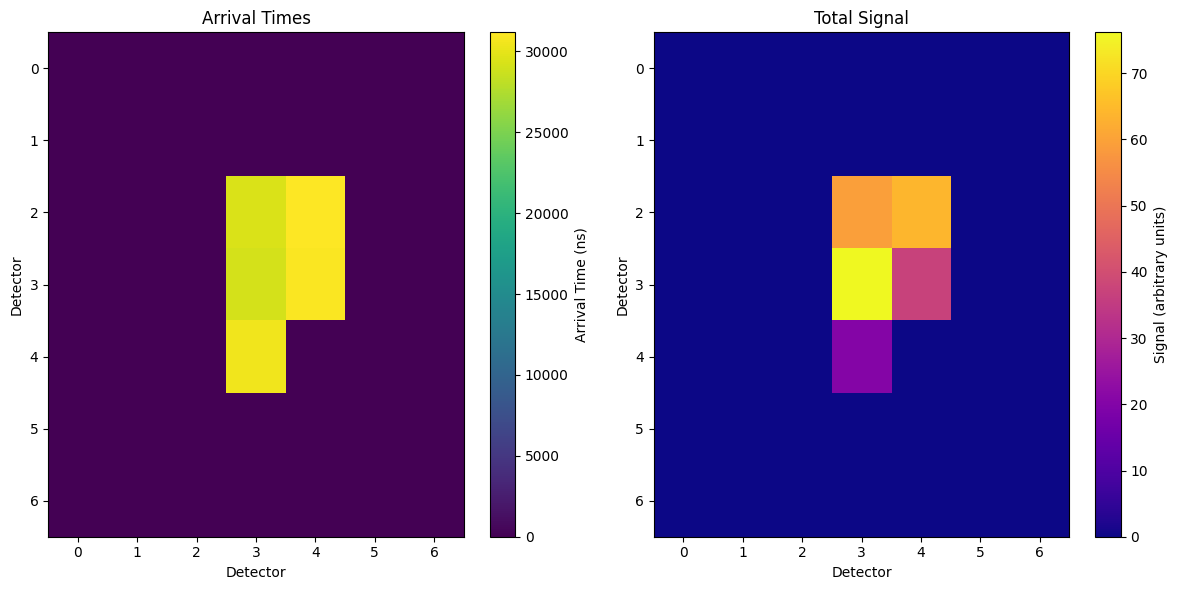

In [4]:
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nArrival times")
arrival_times = data["arrival_times"][evt_id]
print(arrival_times)
print("\nTotal signal")
total_signal = data["total_signal"][evt_id]
print(total_signal)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for Arrival Times
c1 = axs[0].imshow(arrival_times, aspect="auto", cmap="viridis")
axs[0].set_title("Arrival Times")
axs[0].set_xlabel("Detector")
axs[0].set_ylabel("Detector")
plt.colorbar(c1, ax=axs[0], label="Arrival Time (ns)")

# Heatmap for Total Signal
c2 = axs[1].imshow(total_signal, aspect="auto", cmap="plasma")
axs[1].set_title("Total Signal")
axs[1].set_xlabel("Detector")
axs[1].set_ylabel("Detector")
plt.colorbar(c2, ax=axs[1], label="Signal (arbitrary units)")

plt.tight_layout()
plt.show()

#### Normalize data and visualize **normalized** arrival times and total signal

Networks often perform better when the input data is defined within a specific range, meaning that all parameters are within the same range. This is often realized by rescaling or normalizing the data.

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Normalized Arrival Times
[[0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       3.0439599 3.21784   0.1       0.1      ]
 [0.1       0.1       0.1       3.01198   3.20085   0.1       0.1      ]
 [0.1       0.1       0.1       3.14489   0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]]

Normalized Total Signal
[[0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.4102 0.4177 0.     0.    ]
 [0.     0.     0.     0.4346 0.364  0.     0.    ]
 [0.     0.     0.     0.3057 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    

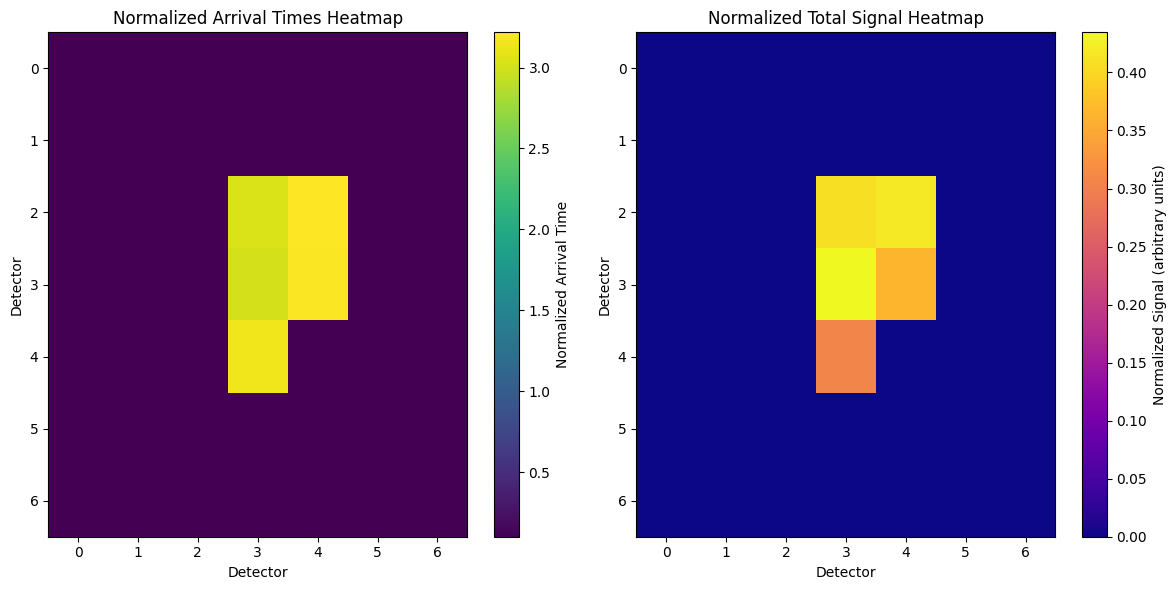

In [5]:
# Normalization and scaling for Arrival Times
min_arrv_times = arrival_times.min()  # Get the minimum arrival time for scaling
shift = 1000  # nanoseconds
scale = 10000  # nanoseconds
arrival_times_scaled = (arrival_times - min_arrv_times + shift) / scale

# Normalization for Total Signal
total_signal_scaled = np.log1p(total_signal) / 10
total_signal_scaled = total_signal_scaled.astype(np.float16)

# Printing outputs
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nNormalized Arrival Times")
print(arrival_times_scaled)
print("\nNormalized Total Signal")
print(total_signal_scaled)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for Normalized Arrival Times
c1 = axs[0].imshow(arrival_times_scaled, aspect="auto", cmap="viridis")
axs[0].set_title("Normalized Arrival Times Heatmap")
axs[0].set_xlabel("Detector")
axs[0].set_ylabel("Detector")
plt.colorbar(c1, ax=axs[0], label="Normalized Arrival Time")

# Heatmap for Normalized Total Signal
c2 = axs[1].imshow(total_signal_scaled, aspect="auto", cmap="plasma")
axs[1].set_title("Normalized Total Signal Heatmap")
axs[1].set_xlabel("Detector")
axs[1].set_ylabel("Detector")
plt.colorbar(c2, ax=axs[1], label="Normalized Signal (arbitrary units)")

plt.tight_layout()
plt.show()

Note: matplotlib has many different colormaps. Choose the most suitable color maps according to your problem. The same data might appear differently in different colormaps.

### 4. Separate data into test and training set

We need to separate the data into a training set and a test set and reshape the data to be used in the network framework. The network cannot handle the 7x7-shaped inputs from two different files (arrays). When you feed data into the neural network model, the 7x7 grid of arrival times and total signals (which is a 2D array) needs to be converted into a 1D array with 49 elements (since 7 × 7 = 49), as we did in the exercises in Basic I. For example, if you have a batch of inputs with the shape (batch_size, 7, 7) (where batch_size is the number of data samples in the batch), you need to "flatten" each 7x7 grid into a 1D vector of length 49 so that the input shape becomes (batch_size, 49).


In [6]:
total_signal_scaled.shape

(7, 7)

In [7]:
data["arrival_times"].shape

(51653, 7, 7)

In [8]:
data["total_signal"].shape

(51653, 7, 7)

In [9]:
total_signal = torch.tensor(data["total_signal"], dtype=torch.float32).to(device)
arrival_time = torch.tensor(data["arrival_times"], dtype=torch.float32).to(device)
energy = torch.tensor(data["energy"], dtype=torch.float32).to(device)


In [10]:
# Flatten the arrays to shape (51653, 49)
total_signal_flat = total_signal.view(total_signal.size(0), -1)  # Shape: (51653, 49)
arrival_time_flat = arrival_time.view(arrival_time.size(0), -1)  # Shape: (51653, 49)

In [11]:
arrival_time_flat.shape

torch.Size([51653, 49])

In [12]:
# Combine flattened arrays if needed (e.g., by concatenation)
# Here we can concatenate both arrays if you want to input both features
combined_features = torch.cat((total_signal_flat, arrival_time_flat), dim=1)  # Shape: (51653, 98)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(combined_features, energy, test_size=0.2, random_state=42)

# Print shapes to verify
print(f'Train feature shape: {X_train.shape}')  # Should be (41322, 98)
print(f'Test feature shape: {X_test.shape}')    # Should be (10331, 98)
print(f'Train target shape: {y_train.shape}')    # Should be (41322, 1)
print(f'Test target shape: {y_test.shape}')      # Should be (10331, 1)


Train feature shape: torch.Size([41322, 98])
Test feature shape: torch.Size([10331, 98])
Train target shape: torch.Size([41322])
Test target shape: torch.Size([10331])


The data set is very large and we can run out of memory quickly. Therefore, training is often done by iterating over smaller batches of the input data.

In [13]:
from torch.utils.data import Dataset, DataLoader

class CosmicRayDataset(Dataset):
    def __init__(self, X_data, y_data):
        # Store the input features (X_data) and target values (y_data)
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.X_data)

    def __getitem__(self, index):
        # Retrieve a single sample at the given index
        X_sample = self.X_data[index]
        y_sample = self.y_data[index]
        # return torch.tensor(X_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)
        return X_sample, y_sample

# Assuming X_train and y_train are NumPy arrays with shape (N, 7, 7) and (N, 1)
dataset = CosmicRayDataset(X_train, y_train)

In [14]:
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
# illustration of batch training and shapes

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 98]) torch.Size([64])


# Exercise:  Train and evalulate the model

We are familiar with this step from the previous exercise and will simply take the same model for regression. We can import the class and function, but for better clarity, we will just copy it from the previous day Basic I. Train and evaluate the model performance on the TA data.